In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from lib.tools import *
from lib.jpeg import *
from lib.decomposition import *
from lib.regression import *
from lib.sketchml import *

# Low rank tensor

## Generate a low rank tensor

In [2]:
tensor_shape = (3,128,128)
tensor_size  = 128*128*3
rank = 3

In [3]:
# CP decomposition: Creating factor matrices for the tensor
# factor_1 = torch.randn(tensor_shape[0], rank)
# factor_2 = torch.randn(tensor_shape[1], rank)
# factor_3 = torch.randn(tensor_shape[2], rank)
# tensor = torch.einsum('ir,jr,kr->ijk', factor_1, factor_2, factor_3)

In [4]:
tensor = torch.zeros(tensor_shape)
for i in range(tensor_shape[0]):
    factor_1 = torch.randn(tensor_shape[1], rank)
    factor_2 = torch.randn(tensor_shape[2], rank)
    tensor_slice = torch.einsum('ir,jr->ij', factor_1, factor_2)
    tensor[i] = tensor_slice

In [5]:
# manipulate the tensor
# value_mask = abs(tensor)>0.01
# tensor = tensor* value_mask

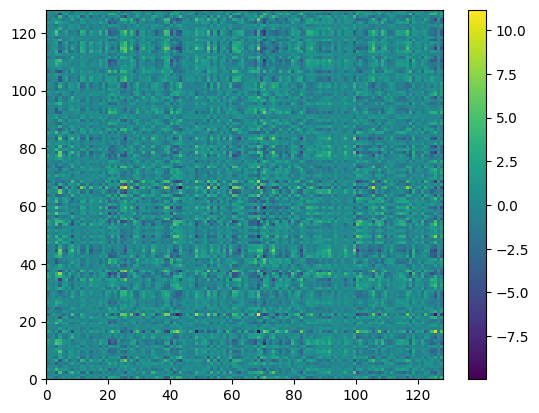

In [6]:
plot_tensor = tensor.reshape([3,128,128])
plt.figure()
plt.pcolormesh(plot_tensor[0])
plt.colorbar()

## Get tensor charateristics

In [7]:
actual_rank= calculate_slice_avg_rank(tensor)
print("The acutal rank of the tensor is: ", actual_rank)

The acutal rank of the tensor is:  3.0


In [8]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.0


## Tensor compression

#### Jpeg

In [9]:
normalize_base, scale,zero_point, encoded_data, compressed_size_jpeg = compressor_jpeg(tensor.reshape([128,128,3]), 100)
print("Compressed size: ", compressed_size_jpeg)

Compressed size:  45178


In [10]:
reconstructed_tensor_jpeg = decompressor_jpeg(tensor.shape,normalize_base, scale,zero_point, encoded_data )
snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
print("Reconstruction snr (dB): ", snr_jpeg)
print("Reconstruction mse: ", mse_jpeg)

Reconstruction snr (dB):  27.3429012298584
Reconstruction mse:  0.0055579194


In [11]:
lowrank_jpeg_ratio = (tensor_size*4) / compressed_size_jpeg
lowrank_jpeg_snr = snr_jpeg
lowrank_jpeg_mse = mse_jpeg / torch.max(tensor).item()

#### Tensor decomposition

In [12]:
factors, compressed_size_decomposition = compressor_decomposition_slice(tensor)
print("Compressed size: ", compressed_size_decomposition)

Compressed size:  9216


In [13]:
reconstructed_tensor_decomposition = decompressor_decomposition_slice(tensor.shape, factors )
snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition.numpy())
mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition.numpy())
print("Reconstruction snr (dB): ", snr_decomposition)
print("Reconstruction mse: ", mse_decomposition)

Reconstruction snr (dB):  131.1159324645996
Reconstruction mse:  2.3313578e-13


In [14]:
lowrank_decomposition_ratio = (tensor_size*4) / compressed_size_decomposition
lowrank_decomposition_snr = snr_decomposition
lowrank_decomposition_mse = mse_decomposition / torch.max(tensor).item()

#### Regression

In [15]:
factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor, 4)
print("Compressed size: ", compressed_size_regression)

Compressed size:  12336.0


In [16]:
reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
print("Reconstruction snr (dB): ", snr_regression)
print("Reconstruction mse: ", mse_regression)

Reconstruction snr (dB):  3.4048399329185486
Reconstruction mse:  1.3763165


In [17]:
lowrank_regression_ratio = (tensor_size*4) / compressed_size_regression
lowrank_regression_snr = snr_regression
lowrank_regression_mse = mse_regression / torch.max(tensor).item()

#### Sketch ML

In [18]:
minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,0.5,3)
print("Compressed size: ", compressed_size_sketchml)

Compressed size:  75438


In [19]:
reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
print("Reconstruction snr (dB): ", snr_sketchml)
print("Reconstruction mse: ", mse_sketchml)

Reconstruction snr (dB):  4.65798556804657
Reconstruction mse:  1.0313445


In [20]:
lowrank_sketchml_ratio = (tensor_size*4) / compressed_size_sketchml
lowrank_sketchml_snr = snr_sketchml
lowrank_sketchml_mse = mse_sketchml / torch.max(tensor).item()

# Image-like tensor

## Generate a image like tensor

In [21]:
import cv2
import torchvision.transforms as transforms

In [22]:
image = cv2.imread("./dataset/jpeg/jpeg422jfif.jpg")
image = cv2.resize(image,(128,128),interpolation = cv2.INTER_AREA)
tensor = torch.from_numpy(image)

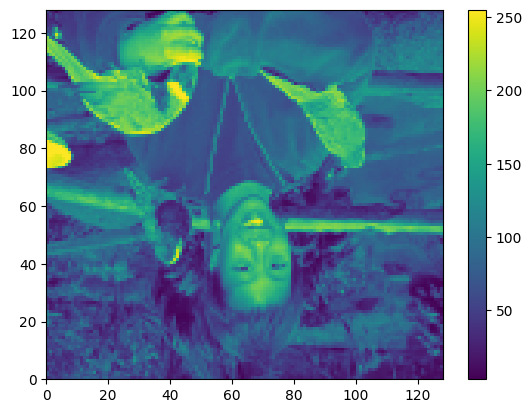

In [23]:
plt.figure()
plt.pcolormesh(tensor[:,:,1])
plt.colorbar()

In [24]:
# manipulate the tensor
value_mask = abs(tensor)>10
tensor = tensor* value_mask

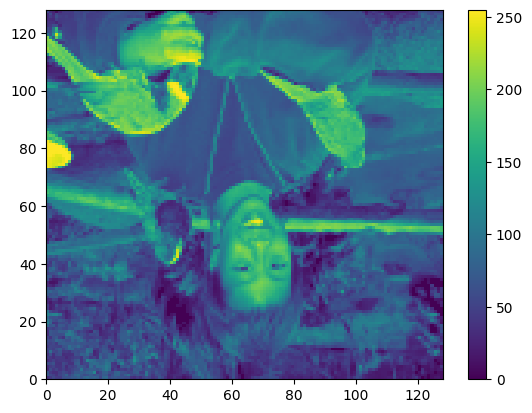

In [25]:
plt.figure()
plt.pcolormesh(tensor[:,:,1])
plt.colorbar()

## Get tensor charateristics

In [26]:
actual_rank= calculate_slice_avg_rank(tensor.reshape([3,128,128]).to(torch.float32))
print("The acutal rank of the tensor is: ", actual_rank)

The acutal rank of the tensor is:  127.66666666666667


In [27]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.014567057291666666


## Tensor compression

#### Jpeg

In [28]:
encoded_data, compressed_size_jpeg = compressor_jpeg_direct(tensor, 95)
print("Compressed size: ", compressed_size_jpeg)

Compressed size:  14282


In [29]:
reconstructed_tensor_jpeg = decompressor_jpeg_direct(tensor.shape, encoded_data )
snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
print("Reconstruction snr (dB): ", snr_jpeg)
print("Reconstruction mse: ", mse_jpeg)

Reconstruction snr (dB):  10.37143463774803
Reconstruction mse:  10.09527587890625


In [30]:
image_jpeg_ratio = (tensor_size*4) / compressed_size_jpeg
image_jpeg_snr = snr_jpeg
image_jpeg_mse = mse_jpeg / torch.max(tensor).item()

#### Tensor decomposition

In [31]:
factors, compressed_size_decomposition = compressor_decomposition_slice(tensor/255)
print("Compressed size: ", compressed_size_decomposition)

Compressed size:  201216


In [32]:
reconstructed_tensor_decomposition = decompressor_decomposition_slice(tensor.shape, factors ) *255
snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition.numpy())
mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition.numpy())
print("Reconstruction snr (dB): ", snr_decomposition)
print("Reconstruction mse: ", mse_decomposition)

Reconstruction snr (dB):  113.469200833813
Reconstruction mse:  4.946996e-10


In [33]:
image_decomposition_ratio = (tensor_size*4) / compressed_size_decomposition
image_decomposition_snr = snr_decomposition
image_decomposition_mse = mse_decomposition / torch.max(tensor).item() # percentage to the max value

#### Regression

In [34]:
factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor.to(torch.float32), 15)
print("Compressed size: ", compressed_size_regression)

Compressed size:  19968.0


In [35]:
reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
print("Reconstruction snr (dB): ", snr_regression)
print("Reconstruction mse: ", mse_regression)

Reconstruction snr (dB):  -7.468763651856384
Reconstruction mse:  613.9571


In [36]:
image_regression_ratio = (tensor_size*4) / compressed_size_regression
image_regression_snr = snr_regression
image_regression_mse = mse_regression/ torch.max(tensor).item()

#### Sketch ML

In [37]:
minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,0.3,5)
print("Compressed size: ", compressed_size_sketchml)

Compressed size:  75453


/home/rex/gitRepo/split_DNN_framework/characteristics/lib/sketchml.py:185: RuntimeWarning: Mean of empty slice.
  bucket_means[k] = values[bucket_mask].mean()
/home/rex/archiconda3/envs/pytorch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [38]:
reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
print("Reconstruction snr (dB): ", snr_sketchml)
print("Reconstruction mse: ", mse_sketchml)

Reconstruction snr (dB):  -11.239780323779405
Reconstruction mse:  1462.9844


In [39]:
image_sketchml_ratio = (tensor_size*4) / compressed_size_sketchml
image_sketchml_snr = snr_sketchml
image_sketchml_mse = mse_sketchml/ torch.max(tensor).item()

# Regular distributed tensor

## Generate a regular distributed tensor

In [40]:
import random

In [41]:
random.seed(5)

In [42]:
tensor = torch.zeros([128,128*3])

In [43]:
for i in range(128):
    a = random.random()
    b = random.random()*2
    c = random.random()
    for j in range(128*3):
        index = j /(128*3)
        if random.random()>0.2:
            tensor[i][j] = a*index -b*index*index+c*index*index*index+ random.random()/10


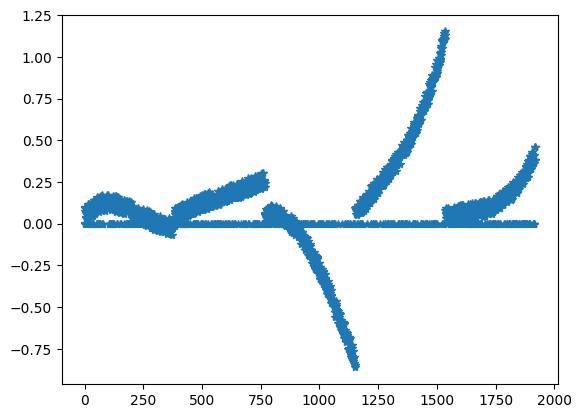

In [44]:
plot_tensor2 = tensor.reshape(128*128*3)
plt.figure()
plt.plot(plot_tensor2[0:1920],"*")

In [45]:
tensor = tensor.reshape([128,128,3])

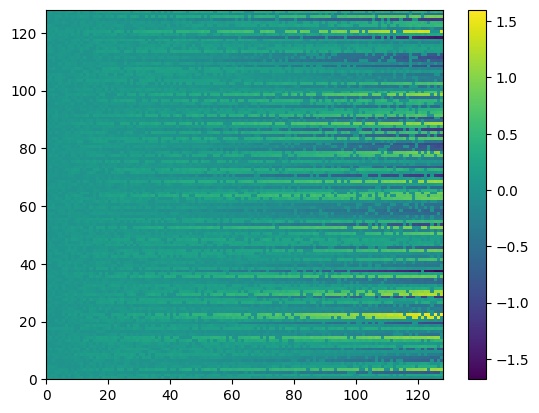

In [46]:
plt.figure()
plt.pcolormesh(tensor[:,:,0])
plt.colorbar()

## Get tensor charateristics

In [47]:
actual_rank= calculate_slice_avg_rank(tensor.reshape([3,128,128]))
print("The acutal rank of the tensor is: ", actual_rank)

The acutal rank of the tensor is:  127.66666666666667


In [48]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.19840494791666666


## Tensor compression

#### Jpeg

In [49]:
normalize_base, scale,zero_point, encoded_data, compressed_size_jpeg = compressor_jpeg(tensor, 100)
print("Compressed size: ", compressed_size_jpeg)

Compressed size:  35915


In [50]:
reconstructed_tensor_jpeg = decompressor_jpeg(tensor.shape, normalize_base, scale,zero_point,encoded_data )
snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
print("Reconstruction snr (dB): ", snr_jpeg)
print("Reconstruction mse: ", mse_jpeg)

Reconstruction snr (dB):  28.916006088256836
Reconstruction mse:  0.000118573225


In [51]:
regular_jpeg_ratio = (tensor_size*4) / compressed_size_jpeg
regular_jpeg_snr = snr_jpeg
regular_jpeg_mse = mse_jpeg / torch.max(tensor).item()

#### Tensor decomposition

In [52]:
factors, compressed_size_decomposition = compressor_decomposition_slice(tensor)
print("Compressed size: ", compressed_size_decomposition)

Compressed size:  201216


In [53]:
reconstructed_tensor_decomposition = decompressor_decomposition_slice(tensor.shape,factors )
snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition.numpy())
mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition.numpy())
print("Reconstruction snr (dB): ", snr_decomposition)
print("Reconstruction mse: ", mse_decomposition)

Reconstruction snr (dB):  136.98442459106445
Reconstruction mse:  1.8498835e-15


In [54]:
regular_decomposition_ratio = (tensor_size*4) / compressed_size_decomposition
regular_decomposition_snr = snr_decomposition
regular_decomposition_mse = mse_decomposition / torch.max(tensor).item() # percentage to the max value

#### Regression

In [55]:
factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor.to(torch.float32), 3)
print("Compressed size: ", compressed_size_regression)

Compressed size:  13824.0


In [56]:
reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
print("Reconstruction snr (dB): ", snr_regression)
print("Reconstruction mse: ", mse_regression)

Reconstruction snr (dB):  20.91989517211914
Reconstruction mse:  0.0007474767


In [57]:
regular_regression_ratio = (tensor_size*4) / compressed_size_regression
regular_regression_snr = snr_regression
regular_regression_mse = mse_regression/ torch.max(tensor).item()

#### Sketch ML

In [58]:
minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,0.3,5)
print("Compressed size: ", compressed_size_sketchml)

Compressed size:  61815


In [59]:
reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
print("Reconstruction snr (dB): ", snr_sketchml)
print("Reconstruction mse: ", mse_sketchml)

Reconstruction snr (dB):  4.757543206214905
Reconstruction mse:  0.03089107


In [60]:
regular_sketchml_ratio = (tensor_size*4) / compressed_size_sketchml
regular_sketchml_snr = snr_sketchml
regular_sketchml_mse = mse_sketchml/ torch.max(tensor).item()

# Non-regular distributed (Random) tensor

## Generate a random tensor

In [86]:
import random

In [87]:
random.seed(5)

In [88]:
tensor = torch.zeros([128,128*3])

In [89]:
for i in range(128):
    for j in range(128*3):
        if random.random()>0.7:
            tensor[i][j] = random.gauss(1,0.3)


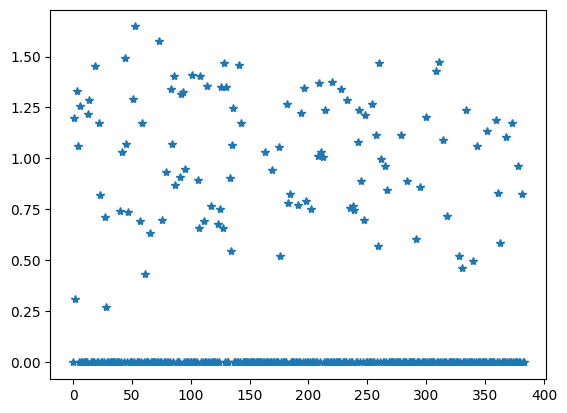

In [90]:
plt.figure()
plt.plot(tensor[0],"*")

In [91]:
tensor = tensor.reshape([128,128,3])

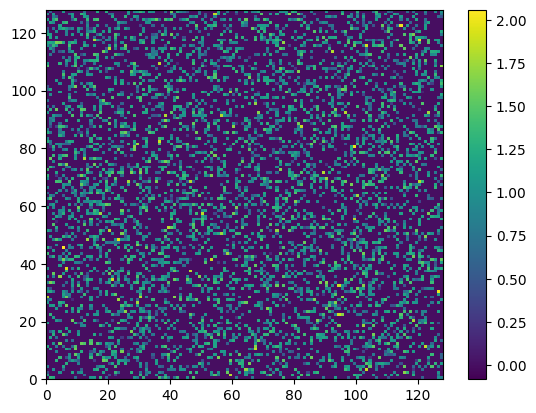

In [92]:
plt.figure()
plt.pcolormesh(tensor[:,:,0])
plt.colorbar()

## Get tensor charateristics

In [93]:
actual_rank= calculate_slice_avg_rank(tensor.reshape([3,128,128]))
print("The acutal rank of the tensor is: ", actual_rank)

The acutal rank of the tensor is:  128.0


In [94]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.7012736002604166


## Tensor compression

#### Jpeg

In [95]:
normalize_base, scale,zero_point, encoded_data, compressed_size_jpeg = compressor_jpeg(tensor, 100)
print("Compressed size: ", compressed_size_jpeg)

Compressed size:  61206


In [96]:
reconstructed_tensor_jpeg = decompressor_jpeg(tensor.shape, normalize_base, scale,zero_point,encoded_data )
snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
print("Reconstruction snr (dB): ", snr_jpeg)
print("Reconstruction mse: ", mse_jpeg)

Reconstruction snr (dB):  17.37385869026184
Reconstruction mse:  0.0059477426


In [97]:
random_jpeg_ratio = (tensor_size*4) / compressed_size_jpeg
random_jpeg_snr = snr_jpeg
random_jpeg_mse = mse_jpeg / torch.max(tensor).item()

#### Tensor decomposition

In [98]:
factors, compressed_size_decomposition = compressor_decomposition_slice(tensor)
print("Compressed size: ", compressed_size_decomposition)

Compressed size:  201216


In [99]:
reconstructed_tensor_decomposition = decompressor_decomposition_slice(tensor.shape,factors )
snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition.numpy())
mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition.numpy())
print("Reconstruction snr (dB): ", snr_decomposition)
print("Reconstruction mse: ", mse_decomposition)

Reconstruction snr (dB):  136.20712280273438
Reconstruction mse:  7.780823e-15


In [100]:
random_decomposition_ratio = (tensor_size*4) / compressed_size_decomposition
random_decomposition_snr = snr_decomposition
random_decomposition_mse = mse_decomposition / torch.max(tensor).item() # percentage to the max value

#### Regression

In [101]:
factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor.to(torch.float32), 10)
print("Compressed size: ", compressed_size_regression)

Compressed size:  17408.0


In [102]:
reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
print("Reconstruction snr (dB): ", snr_regression)
print("Reconstruction mse: ", mse_regression)

Reconstruction snr (dB):  11.211321353912354
Reconstruction mse:  0.024581358


In [103]:
random_regression_ratio = (tensor_size*4) / compressed_size_regression
random_regression_snr = snr_regression
random_regression_mse = mse_regression/ torch.max(tensor).item()

In [104]:
random_regression_ratio

11.294117647058824

#### Sketch ML

In [105]:
minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,0.4,2)
print("Compressed size: ", compressed_size_sketchml)

Compressed size:  12786


In [106]:
reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
print("Reconstruction snr (dB): ", snr_sketchml)
print("Reconstruction mse: ", mse_sketchml)

Reconstruction snr (dB):  11.656291484832764
Reconstruction mse:  0.022187525


In [107]:
random_sketchml_ratio = (tensor_size*4) / compressed_size_sketchml
random_sketchml_snr = snr_sketchml
random_sketchml_mse = mse_sketchml/ torch.max(tensor).item()

# Plotting

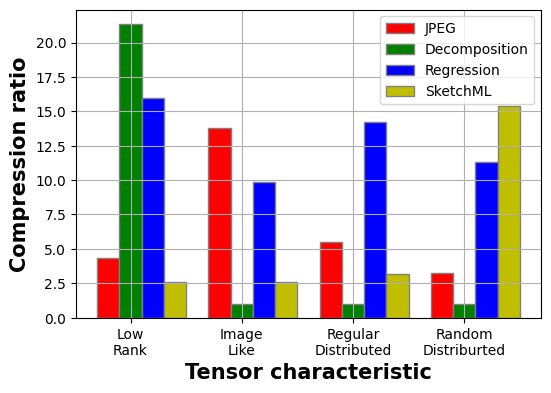

In [108]:
barWidth = 0.2
fig = plt.subplots(figsize =(6, 4)) 

# set height of bar 
jpeg = [lowrank_jpeg_ratio, image_jpeg_ratio,regular_jpeg_ratio,random_jpeg_ratio] 
decomposition = [lowrank_decomposition_ratio, image_decomposition_ratio,regular_decomposition_ratio,random_decomposition_ratio] 
regression = [lowrank_regression_ratio, image_regression_ratio,regular_regression_ratio,random_regression_ratio] 
sketchml = [lowrank_sketchml_ratio, image_sketchml_ratio,regular_sketchml_ratio,random_sketchml_ratio]

# Set position of bar on X axis 
br1 = np.arange(len(jpeg)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, jpeg, color ='r', width = barWidth, 
        edgecolor ='grey', label ='JPEG') 
plt.bar(br2, decomposition, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Decomposition') 
plt.bar(br3, regression, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Regression') 
plt.bar(br4, sketchml, color ='y', width = barWidth, 
        edgecolor ='grey', label ='SketchML') 

# Adding Xticks 
plt.xlabel('Tensor characteristic', fontweight ='bold', fontsize = 15) 
plt.ylabel('Compression ratio', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(jpeg))], 
        ['Low\nRank', 'Image\nLike', 'Regular\nDistributed', 'Random\nDistriburted'])

plt.legend()
plt.grid()
plt.show() 

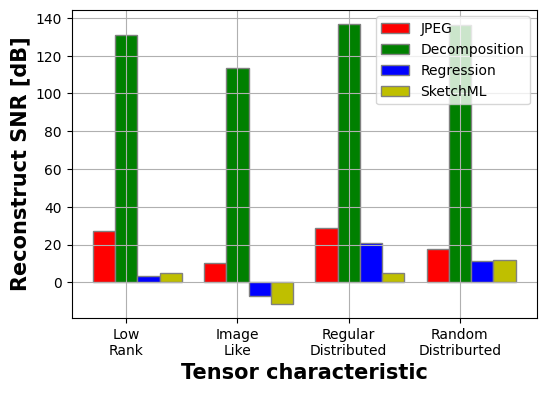

In [109]:
barWidth = 0.2
fig = plt.subplots(figsize =(6, 4)) 

# set height of bar 
jpeg = [lowrank_jpeg_snr, image_jpeg_snr,regular_jpeg_snr,random_jpeg_snr] 
decomposition = [lowrank_decomposition_snr, image_decomposition_snr,regular_decomposition_snr,random_decomposition_snr] 
regression = [lowrank_regression_snr, image_regression_snr,regular_regression_snr,random_regression_snr] 
sketchml = [lowrank_sketchml_snr, image_sketchml_snr,regular_sketchml_snr,random_sketchml_snr]

# Set position of bar on X axis 
br1 = np.arange(len(jpeg)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, jpeg, color ='r', width = barWidth, 
        edgecolor ='grey', label ='JPEG') 
plt.bar(br2, decomposition, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Decomposition') 
plt.bar(br3, regression, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Regression') 
plt.bar(br4, sketchml, color ='y', width = barWidth, 
        edgecolor ='grey', label ='SketchML') 

# Adding Xticks 
plt.xlabel('Tensor characteristic', fontweight ='bold', fontsize = 15) 
plt.ylabel('Reconstruct SNR [dB]', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(jpeg))], 
        ['Low\nRank', 'Image\nLike', 'Regular\nDistributed', 'Random\nDistriburted'])

plt.legend()
plt.grid()
plt.show() 

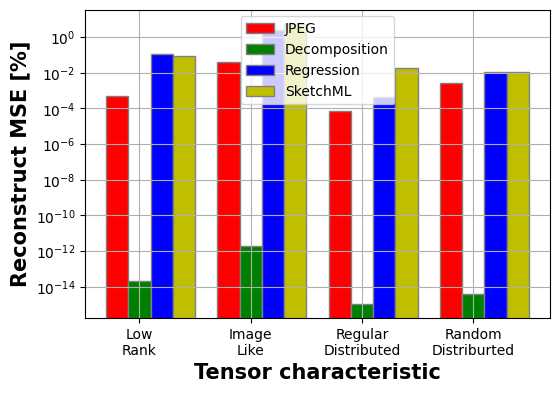

In [110]:
barWidth = 0.2
fig = plt.subplots(figsize =(6, 4)) 

# set height of bar 
jpeg = [lowrank_jpeg_mse, image_jpeg_mse,regular_jpeg_mse,random_jpeg_mse] 
decomposition = [lowrank_decomposition_mse, image_decomposition_mse,regular_decomposition_mse,random_decomposition_mse] 
regression = [lowrank_regression_mse, image_regression_mse,regular_regression_mse,random_regression_mse] 
sketchml = [lowrank_sketchml_mse, image_sketchml_mse,regular_sketchml_mse,random_sketchml_mse]

# Set position of bar on X axis 
br1 = np.arange(len(jpeg)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, jpeg, color ='r', width = barWidth, 
        edgecolor ='grey', label ='JPEG') 
plt.bar(br2, decomposition, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Decomposition') 
plt.bar(br3, regression, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Regression') 
plt.bar(br4, sketchml, color ='y', width = barWidth, 
        edgecolor ='grey', label ='SketchML') 

# Adding Xticks 
plt.xlabel('Tensor characteristic', fontweight ='bold', fontsize = 15) 
plt.ylabel('Reconstruct MSE [%]', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(jpeg))], 
        ['Low\nRank', 'Image\nLike', 'Regular\nDistributed', 'Random\nDistriburted'])

plt.legend()
plt.yscale("log")
plt.grid()
plt.show() 